In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle
import os
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras import regularizers

Using TensorFlow backend.


In [2]:
from models import *

In [3]:
from gen_train_test_data import *
from simtools import *
%load_ext autoreload
%autoreload 2

# load scaler        
with open("model/scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        scaler=pickle.load(f)

In [4]:
date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]

In [5]:
## Global Constants

In [6]:
ticker="TSLA"

time_steps = 50

## Load Models

In [7]:
import os
import re

model_list = os.listdir("model/")
model_list = [s for s in model_list if ((re.search(r'scaler', s) is None) and (re.search(r'[a-zA-Z0-9]*\.p', s)))]

print(model_list)

['Random_Forest_20190102_20190115.p', 'GradientBoost_20190102_20190115.p', 'RandomForest_20190102_20190115.p', 'XGBoost_20190102_20190115.p', 'LSTM_20190102_20190115.p', 'CNN_20190102_20190115.p']


## Model Prediction

In [9]:
import vwap2 as vw
matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]
#test_date_list_new=list(test_taq.keys())
#day = test_taq[test_date_list_new[0]]
#day[~day.trade_px.isna()]

In [10]:
def test_vwap(day, order_quantity, order_side, schedule_coef = -1.0, tick_coef = 0., model_coef = 1.,model=True):
    results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs, schedule_coef = schedule_coef,\
                           tick_coef = tick_coef, model_coef = model_coef, using_model=model)
    display_result(results,False)
    return results

def display_result(results,plot=True):
    data = results['trades']
    if plot:
        print("FV and midpoints:")
        plt.plot(results['fair_values'].index,results['fair_values'].values,color='r')
        plt.plot(results['midpoints'].index,results['midpoints'].values,color='r')
        plt.legend(["fair_values","midpoints"])
        plt.show()
        print("Trade prices:")
        plt.plot(data.price.index,data.price.values,color=taolaoshi[0])
        plt.show()
    print("percentage of aggressive order:",np.mean(data['trade_type']=="a"))
    print("last_min_order:",results['last_min_order'])
    print("avg price:",results['avg_price'])
    print("day_vwap price:",results['day_vwap'])
    print("avg - day_vwap:",results['avg_price'] - results['day_vwap'])

In [28]:
def model_vwap_evaluation(model, order_side):
    for date in test_date_list:
        if not os.path.exists("test_result/x_test_{}.p".format(date)):
            x,idx=create_test_dataset(ticker=ticker,time_steps = time_steps, input_scaler=scaler, date=date)
            print(x.shape,idx.shape)
            with open("test_result/x_test_{}.p".format(date),"wb") as f:
                    pickle.dump(x,f)
        
        x = None
        with open("test_result/x_test_{}.p".format(date),"rb") as f:
            x = pickle.load(f)

        # Using Model for Prediction
        signal=model.predict(x)
        with open("test_result/signal_test_{}.p".format(date),"wb") as f:
                pickle.dump(signal,f)
        
        log_message( "{} finished".format(date) )

    test_taq=dict()

    for date in test_date_list:
        if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):

            with open("test_result/signal_test_{}.p".format(date),"rb") as f:
                signal=pickle.load(f)
            #print(signal[-100:])

            # generate signal and attach it to original df
            if len(signal.shape) > 1:
                signal_discrete=signal.argmax(axis=1)-1
            else:
                signal_discrete=signal
            #signal_continuous=np.dot(signal,np.array([[-1],[0],[1]])).ravel()

            trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
            N=len(trades)

            signal_discrete=np.concatenate((np.zeros(N-len(signal_discrete))+np.nan,signal_discrete), axis=0)
            trades[["signal_discrete"]]=pd.DataFrame({"signal_discrete":signal_discrete,},index=trades.index)

            # merge TAQ
            quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
            taq=makeTAQfile(trades, quotes)
            test_taq[date]=taq

            log_message( "{} finished".format(date) )
    i=0

    vwap_list=[]
    #avg_list_tick=[]
    avg_list_model=[]
    avg_spread=[]

    model_coef=0.1

    for date in test_taq.keys():
        print("-------------------------------------------------------------------------------------------------")
        day=test_taq[date]
        #print("----------------Tick-----------------")
        #r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 1., LSTM_coef = 0.,LSTM=False)
        print("----------------{}-----------------".format(model.model_name))
        r_model=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 0., model_coef = model_coef, model=True)

        vwap_list.append(r_model['day_vwap'])
        #avg_list_tick.append(r_tick['avg_price'])
        avg_list_model.append(r_model['avg_price'])
        avg_spread.append(r_model["avg_spread"])

        log_message( "{} finished".format(date) )
    
    return (vwap_list, avg_list_model, avg_spread, test_taq)

# Running of each model

## CNN

In [18]:
with open("model/CNN_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)

CNN


In [19]:
vwap_list, avg_list_CNN, avg_spread_CNN, test_taq = model_vwap_evaluation(model, 's')

40414
(40365, 50, 4) (40365,)
2020-04-23 16:05:32:288941: 20190117 finished
2020-04-23 16:05:59:819612: 20190118 finished
2020-04-23 16:06:14:384930: 20190122 finished
2020-04-23 16:06:30:796158: 20190123 finished
2020-04-23 16:06:40:601420: 20190124 finished
2020-04-23 16:06:49:997620: 20190125 finished
2020-04-23 16:06:58:524186: 20190128 finished
2020-04-23 16:07:04:471610: 20190129 finished
2020-04-23 16:07:16:103644: 20190130 finished
2020-04-23 16:07:34:406520: 20190131 finished
2020-04-23 16:07:34:518645: start merge
2020-04-23 16:07:34:545789: end merge
2020-04-23 16:07:34:545901: 20190117 finished
2020-04-23 16:07:35:125538: start merge
2020-04-23 16:07:35:297440: end merge
2020-04-23 16:07:35:297559: 20190118 finished
2020-04-23 16:07:35:487298: start merge
2020-04-23 16:07:35:539196: end merge
2020-04-23 16:07:35:539303: 20190124 finished
2020-04-23 16:07:35:707558: start merge
2020-04-23 16:07:35:752512: end merge
2020-04-23 16:07:35:752667: 20190125 finished
2020-04-23 16:

## LSTM

In [20]:
with open("model/LSTM_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)
vwap_list, avg_list_LSTM, avg_spread_LSTM, _ = model_vwap_evaluation(model, 's')

LSTM
2020-04-23 16:16:32:253828: 20190117 finished
2020-04-23 16:24:42:073689: 20190118 finished
2020-04-23 16:28:42:418072: 20190122 finished
2020-04-23 16:33:02:539922: 20190123 finished
2020-04-23 16:36:00:946807: 20190124 finished
2020-04-23 16:38:28:512439: 20190125 finished
2020-04-23 16:40:41:174812: 20190128 finished
2020-04-23 16:42:09:744820: 20190129 finished
2020-04-23 16:45:11:798727: 20190130 finished
2020-04-23 16:49:05:888193: 20190131 finished
2020-04-23 16:49:06:077097: start merge
2020-04-23 16:49:06:111705: end merge
2020-04-23 16:49:06:112280: 20190117 finished
2020-04-23 16:49:06:775891: start merge
2020-04-23 16:49:06:980423: end merge
2020-04-23 16:49:06:981073: 20190118 finished
2020-04-23 16:49:07:225004: start merge
2020-04-23 16:49:07:286605: end merge
2020-04-23 16:49:07:286738: 20190124 finished
2020-04-23 16:49:07:489328: start merge
2020-04-23 16:49:07:546175: end merge
2020-04-23 16:49:07:546299: 20190125 finished
2020-04-23 16:49:07:733344: start merge

## Random Forest

In [29]:
with open("model/Random_Forest_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_RF, avg_spread_RF, _ = model_vwap_evaluation(model, 's')

2020-04-23 17:15:03:803290: 20190117 finished
2020-04-23 17:15:12:385912: 20190118 finished
2020-04-23 17:15:17:850312: 20190122 finished
2020-04-23 17:15:21:529605: 20190123 finished
2020-04-23 17:15:23:756417: 20190124 finished
2020-04-23 17:15:25:783259: 20190125 finished
2020-04-23 17:15:27:485929: 20190128 finished
2020-04-23 17:15:28:724981: 20190129 finished
2020-04-23 17:15:31:960020: 20190130 finished
2020-04-23 17:15:36:063764: 20190131 finished
2020-04-23 17:15:36:156994: start merge
2020-04-23 17:15:36:178777: end merge
2020-04-23 17:15:36:178865: 20190117 finished
2020-04-23 17:15:36:686644: start merge
2020-04-23 17:15:36:853950: end merge
2020-04-23 17:15:36:854087: 20190118 finished
2020-04-23 17:15:37:065518: start merge
2020-04-23 17:15:37:119060: end merge
2020-04-23 17:15:37:119169: 20190124 finished
2020-04-23 17:15:37:261570: start merge
2020-04-23 17:15:37:299678: end merge
2020-04-23 17:15:37:299775: 20190125 finished
2020-04-23 17:15:37:421572: start merge
2020

## Gradient Boost

In [30]:
with open("model/GradientBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_GB, avg_spread_GB, _ = model_vwap_evaluation(model, 's')

2020-04-23 17:23:32:067830: 20190117 finished
2020-04-23 17:23:46:729107: 20190118 finished
2020-04-23 17:23:52:773416: 20190122 finished
2020-04-23 17:23:59:093597: 20190123 finished
2020-04-23 17:24:02:721856: 20190124 finished
2020-04-23 17:24:06:007322: 20190125 finished
2020-04-23 17:24:08:906743: 20190128 finished
2020-04-23 17:24:10:970497: 20190129 finished
2020-04-23 17:24:16:749788: 20190130 finished
2020-04-23 17:24:23:768167: 20190131 finished
2020-04-23 17:24:23:857331: start merge
2020-04-23 17:24:23:881009: end merge
2020-04-23 17:24:23:881114: 20190117 finished
2020-04-23 17:24:24:383450: start merge
2020-04-23 17:24:24:547715: end merge
2020-04-23 17:24:24:547827: 20190118 finished
2020-04-23 17:24:24:725072: start merge
2020-04-23 17:24:24:771478: end merge
2020-04-23 17:24:24:771578: 20190124 finished
2020-04-23 17:24:24:920195: start merge
2020-04-23 17:24:24:963612: end merge
2020-04-23 17:24:24:963748: 20190125 finished
2020-04-23 17:24:25:116364: start merge
2020

## XGBoost

In [31]:
with open("model/XGBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_XGB, avg_spread_XGB, _ = model_vwap_evaluation(model, 's')

2020-04-23 17:32:03:076928: 20190117 finished
2020-04-23 17:32:09:106194: 20190118 finished
2020-04-23 17:32:12:150320: 20190122 finished
2020-04-23 17:32:15:723603: 20190123 finished
2020-04-23 17:32:17:903908: 20190124 finished
2020-04-23 17:32:19:847694: 20190125 finished
2020-04-23 17:32:21:476649: 20190128 finished
2020-04-23 17:32:22:725109: 20190129 finished
2020-04-23 17:32:26:051828: 20190130 finished
2020-04-23 17:32:29:997530: 20190131 finished
2020-04-23 17:32:30:160937: start merge
2020-04-23 17:32:30:188986: end merge
2020-04-23 17:32:30:189098: 20190117 finished
2020-04-23 17:32:30:816741: start merge
2020-04-23 17:32:31:013673: end merge
2020-04-23 17:32:31:013818: 20190118 finished
2020-04-23 17:32:31:232495: start merge
2020-04-23 17:32:31:288962: end merge
2020-04-23 17:32:31:289092: 20190124 finished
2020-04-23 17:32:31:478507: start merge
2020-04-23 17:32:31:529929: end merge
2020-04-23 17:32:31:530042: 20190125 finished
2020-04-23 17:32:31:694651: start merge
2020

## Tick Factor

In [36]:
test_taq=dict()

for date in test_date_list:
    if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):
        
        trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
        
        
        # merge TAQ
        quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
        taq=makeTAQfile(trades, quotes)
        print(taq.shape)
        test_taq[date]=taq
        
        log_message( "{} finished".format(date) )

2020-04-23 17:58:58:863641: start merge
2020-04-23 17:58:58:882777: end merge
(50301, 9)
2020-04-23 17:58:58:882875: 20190117 finished
2020-04-23 17:58:59:323360: start merge
2020-04-23 17:58:59:459393: end merge
(428445, 9)
2020-04-23 17:58:59:459525: 20190118 finished
2020-04-23 17:58:59:610558: start merge
2020-04-23 17:58:59:649588: end merge
(113260, 9)
2020-04-23 17:58:59:649693: 20190124 finished
2020-04-23 17:58:59:782483: start merge
2020-04-23 17:58:59:818529: end merge
(99211, 9)
2020-04-23 17:58:59:818672: 20190125 finished
2020-04-23 17:58:59:931235: start merge
2020-04-23 17:58:59:964147: end merge
(89710, 9)
2020-04-23 17:58:59:964248: 20190128 finished
2020-04-23 17:59:00:064629: start merge
2020-04-23 17:59:00:089848: end merge
(66041, 9)
2020-04-23 17:59:00:089967: 20190129 finished
2020-04-23 17:59:00:299195: start merge
2020-04-23 17:59:00:358964: end merge
(202140, 9)
2020-04-23 17:59:00:359078: 20190130 finished
2020-04-23 17:59:00:589182: start merge
2020-04-23 1

In [40]:
avg_list_tick=[]

model_coef=0.1

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    print("----------------Tick-----------------")
    r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 1., model_coef = 0.,model=False)

    avg_list_tick.append(r_tick['avg_price'])

    log_message( "{} finished".format(date) )

-------------------------------------------------------------------------------------------------
----------------Tick-----------------
2020-04-23 18:00:25:994133: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.1776
2020-04-23 18:00:25:999440: starting main loop
2020-04-23 18:00:46:097925: end simulation loop
2020-04-23 18:00:46:098016: order analytics
2020-04-23 18:00:46:100986: VWAP run complete.
percentage of aggressive order: 0.11376292760540971
last_min_order: 65901.0
avg price: 347.31255029999994
day_vwap price: 347.7609699903627
avg - day_vwap: -0.44841969036275486
2020-04-23 18:00:46:104191: 20190117 finished
-------------------------------------------------------------------------------------------------
----------------Tick-----------------
2020-04-23 18:00:46:104247: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.0542
2020-04-23 18:00:46:119684: starting main loop
2020-04-23 18:02:51:001987: end simulation loop
2020-04-23 18:02

# Comparison of Models

In [ ]:
len(avg_list_tick), len(avg_list_LSTM)

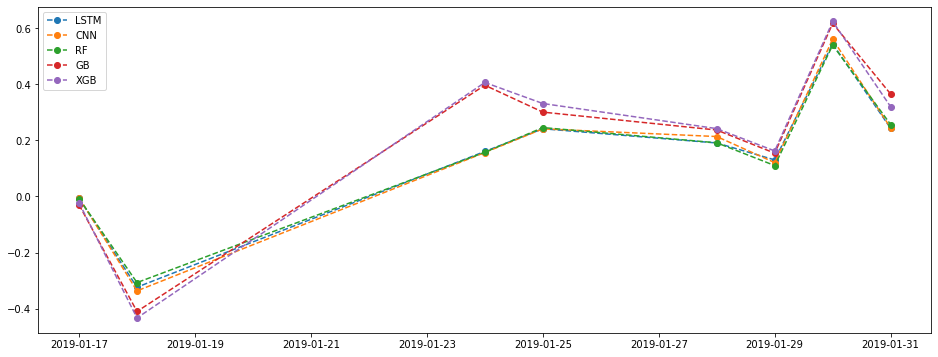

In [45]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick,
                         "LSTM factor":avg_list_LSTM,
                         "CNN factor":avg_list_CNN,
                         "RandomForest factor":avg_list_RF,
                         "GradientBoost factor":avg_list_GB,
                         "XGBoost factor":avg_list_XGB,
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])